# Principal Component Analysis

Vamos a generar un set de datos con correlación definida, y luego le vamos a sumar ruido

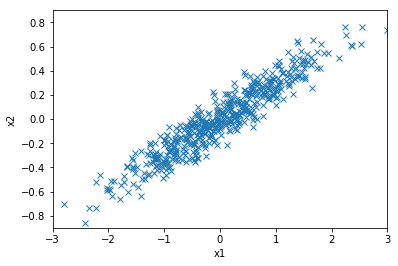

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plot
import math
fr=0.1
N=500
factor=0.3

#Genero valores aleatorios para x1 y luego genero x2 multiplicando x1 por un factor
x1=np.random.randn(N)
x2=x1*factor

#Contamino las muestras x1 y x2 con ruido
x1=x1+np.random.randn(N)*fr
x2=x2+np.random.randn(N)*fr

#Grafico x1 y x2 
plot.plot(x1,x2,'x')
plot.ylabel('x2')
plot.xlabel('x1')
plot.axis([-3,3, -3*factor, 3*factor])
plot.show()




Vamos a estimar la matriz de covarianza perteneciente al set de datos. Lo haremos manualmente y con la función que viene en numpy, luego compararemos los resultados.

In [2]:
#Reservo espacio para la matriz de covarianza
C=np.zeros((2,2))

#Estimo la covarianza sumando los productos cruzados y luego normalizo con respecto a (N-1)
for i in range(N):
    C[0][0]+=x1[i]*x1[i]
    C[0][1]+=x1[i]*x2[i]
    C[1][0]+=x2[i]*x1[i]
    C[1][1]+=x2[i]*x2[i]

C/=(N-1)
print('La matriz de covarianza calculada a mano es:')
print(C)

#Calculo la matriz de covarianza usando la función de Python

C=np.cov((x1,x2))
print('La matriz de covarianza usando numpy es:')
print(C)

La matriz de covarianza calculada a mano es:
[[ 0.9422571   0.27386172]
 [ 0.27386172  0.08885057]]
La matriz de covarianza usando numpy es:
[[ 0.94204564  0.27379173]
 [ 0.27379173  0.08882741]]


Ahora calcularemos los autovalores y autovectores de la matriz de covarianza y graficaremos los datos con los autovectores.

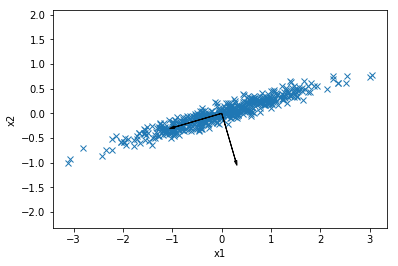

In [3]:
(auval,auvec)=np.linalg.eigh(C)
plot.plot(x1,x2,'x',zorder=1)
plot.ylabel('x2')
plot.xlabel('x1')
plot.arrow(0, 0, auvec[1][0], auvec[1][1], head_width=0.05, head_length=0.1, fc='k', ec='k')
plot.arrow(0, 0, auvec[0][0], auvec[0][1], head_width=0.05, head_length=0.1, fc='k', ec='k')
plot.axis([-3,3, -3*factor, 3*factor])
plot.axis('equal')
plot.show()

Vamos a transformar los datos de entrada al nuevo par de coordenadas y vamos a graficarlos

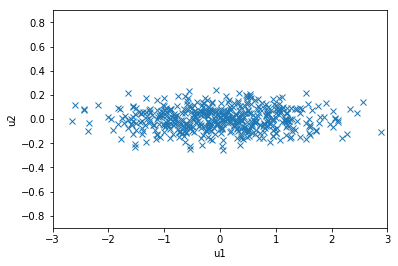

In [4]:
#Transformo los datos de entrada con la base de autovectores
u=np.dot(auvec,(x1,x2))

#genero las variables x1prima y x2prima: recordar que eigh devuelve los autovalores de menor a mayor, corrijo esto con los índices
u1=u[1]
u2=u[0]
plot.plot(u1,u2,'x')
plot.ylabel('u2')
plot.xlabel('u1')
plot.axis([-3,3, -3*factor, 3*factor])
plot.show()


Ahora hago la componente u2=0, por no tener energía apreciable, por lo que podría a limitarme a almacenar solamente u1 y el otro dato desecharlo. 

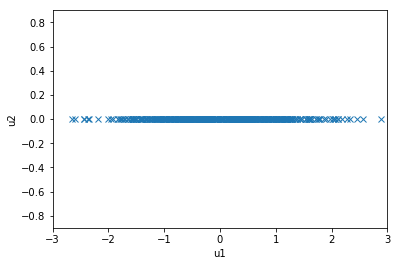

In [5]:
u2=np.zeros(N)
plot.plot(u1,u2,'x')
plot.ylabel('u2')
plot.xlabel('u1')
plot.axis([-3,3, -3*factor, 3*factor])
plot.show()

Antitransformo los datos, aprovechando la propiedad de que la inversa de la matriz de autovectores, es la transpuesta.

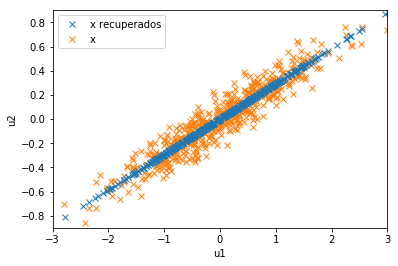

In [6]:
#Transformo los datos de comprimidos con la transpuesta de los autovectores
xrec=np.dot(np.matrix.transpose(auvec),(u2,u1))

#Recupero los datos en su representación original y los grafico contra los datos originales
x1rec=xrec[0]
x2rec=xrec[1]
plot.plot(x1rec,x2rec,'x',label='x recuperados')
plot.plot(x1,x2,'x',zorder=1, label='x')
plot.ylabel('u2')
plot.xlabel('u1')
plot.legend()
plot.axis([-3,3, -3*factor, 3*factor])
plot.show()

## Ejemplo con ECGs de Physionet



In [532]:
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plot
from IPython.display import display

In [541]:
# Importo los datos del dataset 100 de mitdb
signals2, fields2=wfdb.srdsamp('100', channels=[0,1], sampfrom=0, sampto=100000, pbdir = 'mitdb') 
# Importo las anotaciones del mismo dataset
annotation = wfdb.rdann('100', 'atr', sampfrom = 0, sampto = 100000, pbdir = 'mitdb')
#Me quedo con los picos de cada ECG que es donde están las anotaciones
picos=annotation.annsamp

#Transpongo las señales leídas para poder operar mas comodamente
signals=np.matrix.transpose(signals2)
picos[-1]=0 #descarto el último pico por si el latido está interrumpido
tam=125 #Tamaño del latido que tomo a la izquierda y a la derecha de la anotación
cantLatidos=sum(picos>tam) #Cuento la cantidad de anotaciones en el segemento a analizar
latidos=np.zeros([cantLatidos,2*tam]) #Reservo espacio para la matriz de datos cantLatidos x 2*tam
latidosNorm=np.zeros([2*tam,cantLatidos])#Reservo espacio para la matriz de datos normalizados
numLat=0 #Inicializo en cero para procesar cada uno de los picos
for i in picos:
    if i>tam: # i>tam por si el primer latido está trunco
        latidos[numLat]=signals[0][i-tam:i+tam] #tomo tam muestras a la izquerda y a la derecha de la anotación
        numLat+=1 #incremento el número de latidos

#El set de latidos está en latidos y el largo de cada latido es de tam muestras

latidos=np.matrix.transpose(latidos) #vuelvo a acondicionar los latidos para seguir operando cómodamente

# A continuación calculo la media y la varianza de cada elemento del vector de datos para poder normalizar cada dato
medias=np.zeros(2*tam)
desv=np.zeros(2*tam)
for i in range(0,2*tam):
    medias[i]=np.mean(latidos[i,:])
    desv[i]=np.std(latidos[i,:])

In [542]:
# Normalizo cada latido
for idx in range(0,2*tam):
    latidosNorm[idx]=latidos[idx]-np.ones(cantLatidos)*medias[idx]
    latidosNorm[idx]=latidosNorm[idx]/desv[idx]

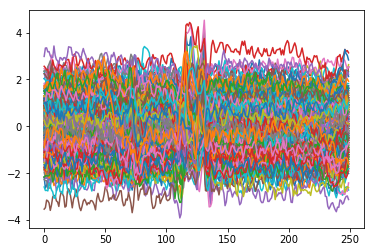

In [543]:
#Grafico los latidos normalizados
plot.plot(latidosNorm)
plot.show()

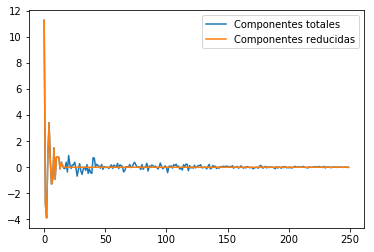

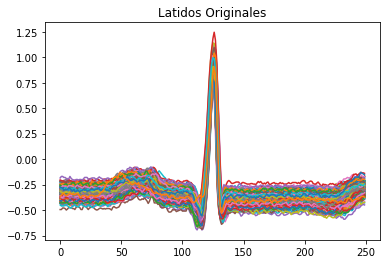

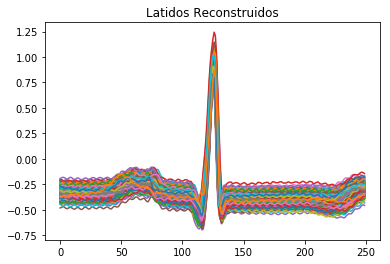

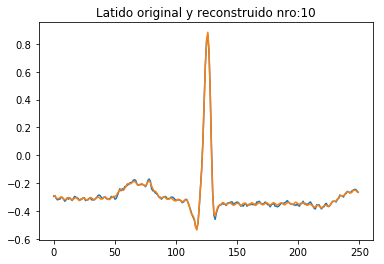

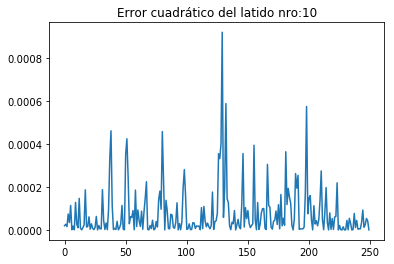

La potencia de la señal original es:
0.0270275904
La potencia de la señal de salida es:
0.0270322867132


In [557]:
# A continuación transformo los datos de entrada al espacio PCA y me quedo con las cantDim componentes de mayor 
# energía de la señal. El resto de los componentes los hago cero.

cantDim=16
analizarLatido=10 #Elijo un latido en particular para después comparar el original con el reconstruído

#Calculo la matriz de covarianza y luego calculo los autovectores y autovalores
C=np.cov(latidosNorm)
(auval,auvec)=np.linalg.eigh(C)

#Ordeno los autovalores de mayor a menor, y los autovectores en consecuencia, para que el orden coincida con
#el orden de la implementación de PCA de numpy
idx = auval.argsort()[::-1]   
auval = auval[idx]
auvec = auvec[:,idx]


#Transpongo los autovectores para poder usar np.dot
auvec=np.matrix.transpose(auvec)

u=np.dot(auvec,latidosNorm)#transformo los latidos normalizados al espacio PCA
plot.plot(np.matrix.transpose(u)[analizarLatido],label='Componentes totales')
u[cantDim:2*tam]=0 #Hago cero las componentes mayores a cantDim
plot.plot(np.matrix.transpose(u)[analizarLatido],label='Componentes reducidas')
plot.legend()
plot.show()
latidosRec=np.dot(np.matrix.transpose(auvec),u)
for idx in range(0,2*tam):
    latidosRec[idx]=latidosRec[idx]*desv[idx]+np.ones(cantLatidos)*medias[idx]
    
plot.plot(latidos)
plot.title('Latidos Originales')
plot.show()
plot.plot(latidosRec)
plot.title('Latidos Reconstruidos')
plot.show()
plot.plot(np.matrix.transpose(latidos)[analizarLatido])
plot.plot(np.matrix.transpose(latidosRec)[analizarLatido])
plot.title('Latido original y reconstruido nro:' + str(analizarLatido))
plot.show()
plot.plot((np.matrix.transpose(latidos)[analizarLatido] - np.matrix.transpose(latidosRec)[analizarLatido])**2)
plot.title('Error cuadrático del latido nro:' + str(analizarLatido))
plot.show()
plot.show()
print('La potencia de la señal original es:')
print(np.var(np.matrix.transpose(latidos)[analizarLatido]))
print('La potencia de la señal de salida es:')
print(np.var(np.matrix.transpose(latidosRec)[analizarLatido]))

Ahora vamos a comparar los resultados del PCA implementado a mano con los resultados del PCA provisto por numpy

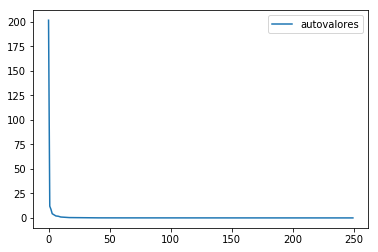

In [558]:
plot.plot(auval,label='autovalores')
plot.legend()
plot.show()

In [559]:
from matplotlib.mlab import PCA
results = PCA(np.matrix.transpose(latidos))

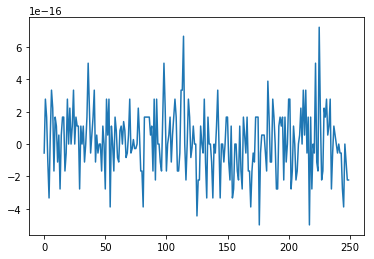

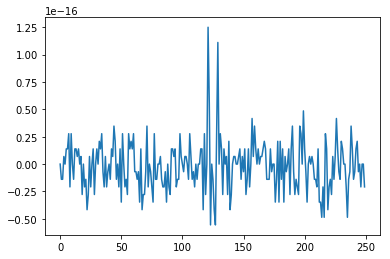

In [560]:
plot.plot(results.mu-medias)
plot.show()
plot.plot(results.sigma-desv)
plot.show()


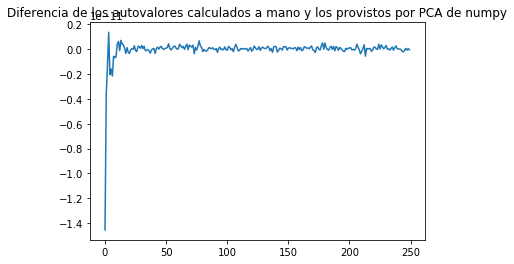

In [561]:
plot.plot(auval*(cantLatidos-1)-results.s)
plot.title('Diferencia de los autovalores calculados a mano y los provistos por PCA de numpy')
plot.show()

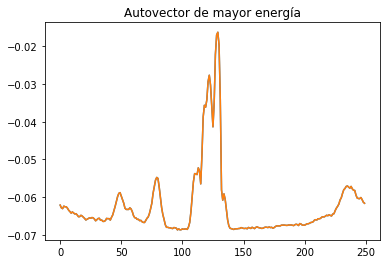

In [562]:
plot.plot(results.Wt[0])
plot.plot(-1*auvec[0])
plot.title('Autovector de mayor energía')
plot.show()